---
title: "算法交易：制胜策略与原理(欧内斯特·陈)之三"
author: 王一刀
categories: [算法交易]
date: 2024-08-29
format: html
---

应用价差、价差的对数或相应比率所进行的配对交易

hedgeRatio: [       nan        nan        nan ... 0.15994561 0.18147442        nan]
ts.add_constant(-hedgeRatio): [[ 1.                 nan]
 [ 1.                 nan]
 [ 1.                 nan]
 ...
 [ 1.         -0.15994561]
 [ 1.         -0.18147442]
 [ 1.                 nan]]
numUnits: Date
2006-04-26         NaN
2006-04-27         NaN
2006-04-28         NaN
2006-05-01         NaN
2006-05-02         NaN
                ...   
2012-04-02    0.885846
2012-04-03    1.690156
2012-04-04    2.805475
2012-04-05    2.581271
2012-04-09   -1.475398
Length: 1500, dtype: float64
APR=0.109551 Sharpe=0.598899


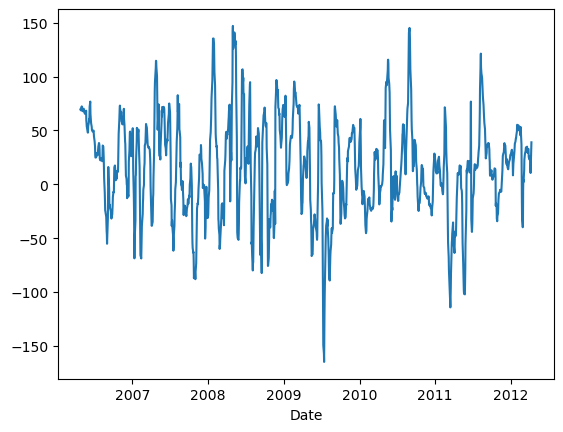

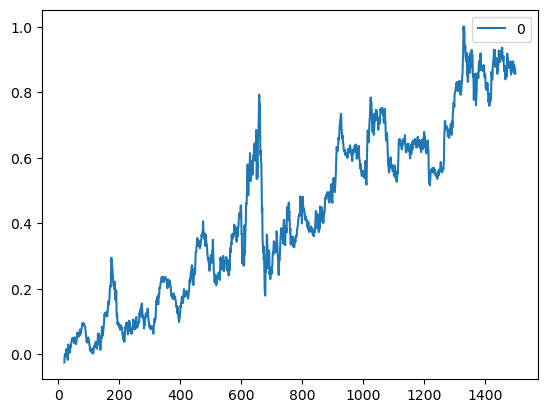

In [8]:
# Trading Price Spread

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

lookback=20
hedgeRatio=np.full(df.shape[0], np.nan)
# 计算对冲比率
for t in np.arange(lookback, len(hedgeRatio)):
    regress_results=sm.ols(formula="USO ~ GLD", data=df[(t-lookback):t]).fit() # Note this can deal with NaN in top row
    hedgeRatio[t-1]=regress_results.params.iloc[1]
print('hedgeRatio:',hedgeRatio)
print('ts.add_constant(-hedgeRatio):',ts.add_constant(-hedgeRatio))
# 计算投资组合净值
yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*df, axis=1)
yport.plot()

# Apply a simple linear mean reversion strategy to GLD-USO
# 实现简单的线性均值回归策略

# 计算投资单位数。这个公式实际上是计算yport与其移动平均值的偏差，然后除以其标准差。
# 这个值表示相对于其历史平均表现，今天的投资组合表现有多好（或有多差）。正值表示今天的表现优于平均水平，负值表示今天的表现低于平均水平。
# 乘以-1是为了反转符号，使得正值表示买入，负值表示卖出。
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
print('numUnits:',numUnits)
# np.tile(numUnits.values, [2, 1]):
# np.tile函数用于重复数组的元素以创建新的数组。
# numUnits.values是一个一维数组（假设numUnits只有一列），[2, 1]表示在行方向上重复两次，在列方向上重复一次。
# 结果是一个二维数组，其中第一行是numUnits.values的复制，第二行也是numUnit.values的复制。
positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * ts.add_constant(-hedgeRatio)[:, [1,0]] *df.values) # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
# np.cumprod 是 NumPy 库中的一个函数，用于计算数组的累积积（cumulative product）。
# 累积积是指从数组的第一个元素开始，逐个元素相乘，直到当前元素为止的所有元素的乘积
pd.DataFrame((np.cumprod(1+ret)-1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
